# Results Summary

A notebook for plotting all of the results of Garcia, McMahon, Conwell, Bonner, & Isik. 

The user should run all cells in the **Setup** section. All other parts of the code are modular and can be run as independent sections. 

*Note*: The loading a lot of neural results is relatively slow. 

## Setup

In [ ]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
from itertools import product
from pathlib import Path
import re

### Loading functions

In [31]:
def load_single_file(file_):
    if 'csv' in file_:
        return pd.read_csv(file_)
    else:
        return pd.read_pickle(file_)

    
def load_all_files(path, perturbation=False):
    if type(path) is str: 
        files = glob(path)
    else: #type(path) is list
        files = []
        for p in path:
            files += glob(p)
    
    print(f'{len(files)} files found')
    out_ = []
    for file in tqdm(files, desc='Loading files'):
        try:
            cdf = load_single_file(file)
            cdf[['train_score', 'test_score']] = cdf[['train_score', 'test_score']].astype('float32')
            if 'roi_name' in cdf.columns.tolist():
                cdf = cdf[cdf['roi_name'] != 'none'].reset_index(drop=True)
                
            if 'r_var_dist' in cdf.columns.tolist():
                cdf.drop(columns=['r_var_dist', 'r_null_dist'], inplace=True)
                
            if perturbation:
                cdf = add_perturbation(file, cdf)
                
            out_.append(add_model_class(file, cdf))
        except:
            print(f'could not load {file.split('/')[-1]}')
    return pd.concat(out_)


def add_model_class(file_, df_):
    if 'Vision' in file_:
        df_['model_class'] = 'image'
    elif 'Video' in file_:
        df_['model_class'] = 'video'
    else:
        df_['model_class'] = 'language'
    return df_

def add_perturbation(file_, df_):
    if 'no_perturbation' in file_:
        df_['perturbation'] = 'original'
    elif 'mask_nonverbs' in file_:
        df_['perturbation'] = 'only verbs'
    elif 'mask_nonnouns' in file_:
        df_['perturbation'] = 'only nouns'
    elif 'mask_nonprepositions' in file_:
        df_['perturbation'] = 'only prepositions'
    elif 'mask_nonadjectives' in file_:
        df_['perturbation'] = 'only adjectives'
    elif 'mask_nouns' in file_:
        df_['perturbation'] = 'no nouns'
    elif 'mask_prepositions' in file_:
        df_['perturbation'] = 'no prepositions'
    elif 'mask_adjectives' in file_:
        df_['perturbation'] = 'no adjectives'
    else:
        df_['perturbation'] = 'no verbs'
    return df_

### Preprocessing functions

In [32]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]


def behavior_max(df_):
    out_ = df_.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
    rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in out_.feature.unique()}
    out_ = pd.melt(out_, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                        value_vars=["train_score", "test_score"], 
                        var_name="set", value_name="score")
    out_['feature'] = out_['feature'].replace(rename_mapping)
    out_['feature'] = pd.Categorical(out_['feature'], categories=annotated_features, ordered=True)
    out_['set'] = out_['set'].replace({'train_score': 'train', 'test_score': 'test'})
    out_['set'] = pd.Categorical(out_['set'], categories=['train', 'test'], ordered=True)
    return out_


def combined_behavior_max(df_):
    out_ = df_.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
    rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in out_.feature.unique()}
    out_['feature'] = out_['feature'].replace(rename_mapping)
    out_['feature'] = pd.Categorical(out_['feature'], categories=annotated_features, ordered=True)
    out_['model_class'] = pd.Categorical(out_['model_class'], categories=['image', 'video', 'language'], ordered=True)
    return out_


def perturbation_behavior_max(df_):
    out_ = df_.groupby(['feature', 'model_uid', 'perturbation']).apply(get_max_score).reset_index(drop=True)
    rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in out_.feature.unique()}
    out_['feature'] = out_['feature'].replace(rename_mapping)
    out_['feature'] = pd.Categorical(out_['feature'], categories=annotated_features, ordered=True)
    out_['perturbation'] = pd.Categorical(out_['perturbation'], categories=perturbations, ordered=True)
    return out_


def neural_max(df_):
    # get average within subject first
    out_ = df_.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
    #now get average across subjects
    out_ = out_.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
    out_ = out_.loc[out_.roi_name.isin(rois)].reset_index(drop=True)
    out_ = pd.melt(out_, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                        value_vars=["train_score", "test_score"], 
                        var_name="set", value_name="score")
    out_['roi_name'] = pd.Categorical(out_['roi_name'], categories=rois, ordered=True)
    out_['set'] = out_['set'].replace({'train_score': 'train', 'test_score': 'test'})
    out_['set'] = pd.Categorical(out_['set'], categories=['train', 'test'], ordered=True)
    out_['normalized_score'] = out_['score'] / out_['reliability']
    return out_


def combined_neural_max(df_):
    out_ = df_.groupby(['subj_id', 'roi_name',
                        'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
    out_ = out_.groupby(['roi_name', 'model_uid',
                         'model_class']).mean(numeric_only=True).reset_index()
    out_ = out_.loc[out_.roi_name.isin(rois)].reset_index(drop=True)
    out_['model_class'] = pd.Categorical(out_['model_class'],
                                         categories=['image', 'video', 'language'],
                                         ordered=True)
    out_['roi_name'] = pd.Categorical(out_['roi_name'], categories=rois, ordered=True)
    out_['normalized_score'] = out_['test_score'] / out_['reliability']
    return out_


def clean_slip(df_, slip_version, train_set='yfcc15m'):
    pattern=fr"{slip_version}_(.*?)_{train_set}"
    out_ = df_.loc[df_.model_uid.str.contains(slip_version)].reset_index()
    rename_mapping = {}
    for model in out_.model_uid.unique():
        if re.search(pattern, model):
            rename_mapping[model] = re.search(pattern, model).group(1)
        else:
            rename_mapping[model] = 'slip'
    out_['model_uid'] = out_['model_uid'].replace(rename_mapping)
    return out_

### Behavior plotting functions

In [33]:
def behavior_slip_plot(df_, reliability_, title=None):
    fig, ax = plt.subplots()
    sns.barplot(x='feature', y='test_score', hue='model_uid',
              data=df_, ax=ax, zorder=0)
    sns.pointplot(x='feature', y='reliability', data=reliability_,
              ax=ax, linestyle="none", errorbar=None, 
              marker="_", markersize=30, markeredgewidth=7,
              color='gray', alpha=.5, zorder=1)
    ax.legend(loc='center right', bbox_to_anchor=(1.5, .75),
          ncol=1, fancybox=True)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Score ($r$)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.suptitle(title)

In [34]:
def plot_behavior_summary(df_, reliability_, out_file=None): 
    _, ax = plt.subplots(figsize=(8.5,4))
    sns.set_palette('mako_r')
    color = ['gray', 'gray', 'gray']

    sns.stripplot(x='feature', y='score', hue='set', data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    sns.pointplot(x='feature', y='score', hue='set', data=df_,
                   dodge=.4, linestyle="none", errorbar=None,
                  marker="_", markersize=20, markeredgewidth=3, zorder=1)
    sns.pointplot(x='feature', y='reliability', data=reliability_,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=30, markeredgewidth=7,
                  color='gray', alpha=.5, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylim([-.4, 1])
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15),
              ncol=2, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file)
        
def plot_perturbation_summary(df_, reliability_, out_file=None,
                              y_var='test_score', y_label='Score ($r$)', 
                              plot_reliability=True,
                              palette=None):
    if palette is None:
        palette = sns.color_palette("husl", df_.perturbation.nunique())
    _, ax = plt.subplots(figsize=(8.5,4))
    sns.set_palette('icefire_r')
    color = ['gray', 'gray', 'gray']
    sns.barplot(x='feature', y=y_var, hue='perturbation',
                data=df_, palette=palette)
    if plot_reliability: 
        sns.pointplot(x='feature', y='reliability', data=reliability_,
                      ax=ax, linestyle="none", errorbar=None, 
                      marker="_", markersize=30, markeredgewidth=7,
                      color='gray', alpha=.5, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    ax.set_ylim([-0.6, .1])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file)

In [35]:
def plot_combined_behavior_summary(df_, reliability_, out_file=None,
                                   annotations=False,
                                   model_uids_to_annotate=['gpt2'],
                                   model_name_to_show=['gpt2'],
                                   annotation_features=['expanse', 'communication']):
    if annotations: 
        rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
        offset_positions = [(-25, -80), (5, -60), (-10, 60), (25, 40)]
        offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
        dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter

    _, ax = plt.subplots(figsize=(8.5,4))
    sns.set_palette('icefire_r')
    color = ['gray', 'gray', 'gray']
    sns.stripplot(x='feature', y='test_score', hue='model_class', data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    strip_collections = ax.collections
    sns.pointplot(x='feature', y='test_score', hue='model_class', data=df_,
                   dodge=.55, linestyle="none", errorbar=None,
                  marker="_", markersize=14, markeredgewidth=3, zorder=1)
    sns.pointplot(x='feature', y='reliability', data=reliability_,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=30, markeredgewidth=7,
                  color='gray', alpha=.5, zorder=1)
    if annotations: 
        # Loop through the DataFrame and annotate the points for select model_uids
        for _, row in df_.iterrows():
            if (row['model_uid'] in model_uids_to_annotate and row['feature'] in annotation_features):
                # Get the index of the relevant stripplot
                c_names = list(product(annotated_features, list(df_.model_class.unique())))
                matching_indices = [index for index, (feature, mclass) in enumerate(c_names) if feature == row['feature'] and mclass == row['model_class']][0]
                stripplot_points = strip_collections[matching_indices].get_offsets()

                # Find the closest point to the intended test_score
                closest_point_idx = np.where(np.isclose(stripplot_points[:, 1], row['test_score']))[0][0]
                closest_point = stripplot_points[closest_point_idx]

                ax.annotate(rename_mapping[row['model_uid']],
                            xy=closest_point,  # Use the closest stripplot point
                            xytext=offset_mapping[row['model_uid']],  # Offset for the annotation
                            textcoords='offset points',
                            ha='center',
                            fontsize=8,  # Adjust the text size if needed
                            arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0"))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Score ($r$)')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file)

### Neural plotting functions

In [36]:
sns.set_context('talk')

def plot_neural_summary(df_, out_file=None):
    _, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
    sns.set_palette('mako_r')
    color = ['gray', 'gray', 'gray']
    for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
        legend = True if i_ax == 0 else False
        cur_scores = df_.loc[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        strip_collections = ax.collections
        sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                      ax=ax, linestyle="none", errorbar=None, 
                      marker="_", markersize=30, markeredgewidth=7,
                      color='gray', alpha=.5, zorder=1)
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=legend, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('')
        ax.set_ylim([0, .7])
        if i_ax == 0: 
            ax.set_ylabel('Score ($r$)')
            ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                      ncol=2, fancybox=True)
        
    if out_file is not None:
        plt.savefig(out_file)
        
def plot_normalized_neural_summary(df_, out_file=None):
    _, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
    sns.set_palette('mako_r')
    color = ['gray', 'gray', 'gray']
    for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
        legend = True if i_ax == 0 else False
        cur_scores = df_.loc[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=legend, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('')
        ax.set_ylim([0, 1])
        if i_ax == 0: 
            ax.set_ylabel('Normalized score ($r$)')
            ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                      ncol=2, fancybox=True)
    
    if out_file is not None:
        plt.savefig(out_file)
        
        
def plot_neural_hierarchy(df_, out_file=None):
    _, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
    sns.set_palette('mako_r')
    color = ['gray', 'gray', 'gray']
    unique_model_uids = df_['model_uid'].unique()
    color_palette = {uid: 'gray' for uid in unique_model_uids}
    df_test = df_[df_.set == 'test']
    for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
        cur_scores = df_test[df_test.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        cur_scores_avg = cur_scores.groupby('roi_name', observed=True).mean(numeric_only=True)
        sns.pointplot(x='roi_name', y='layer_relative_depth', data=cur_scores_avg,
                     marker='.', markersize=10, zorder=1, color='purple',
                     ax=ax, legend=False)
        sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid',
                     data=cur_scores, ax=ax,
                     linewidth=.5, alpha=0.25, zorder=0,
                     legend=False, palette=color_palette)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim([0,1])
        ax.set_xlabel('')
        if i_ax == 0:
            ax.set_ylabel('Relative layer depth')
    if out_file is not None:
        plt.savefig(out_file)

In [37]:
def neural_slip_plot(df_, title=None):
    fig, axes = plt.subplots(1, 2, figsize=(8.5, 5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                               ['FFA', 'PPA']])):
        legend = True if i_ax == 1 else False
        roi_positions = {roi: i for i, roi in enumerate(cur_rois)}

        cur_scores = df_[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        sns.barplot(x='roi_name', y='test_score', hue='model_uid',
                    data=cur_scores, ax=ax, zorder=0, legend=legend)
        sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                  linestyle="none", errorbar=None, color='gray',
                  marker="_", markersize=50, markeredgewidth=10,
                  alpha=.5, zorder=1, ax=ax)
        if i_ax == 0: 
            ax.set_ylabel('Score ($r$)')
        else:
            ax.legend(loc='center right', bbox_to_anchor=(2.5, .5),
                      ncol=1, fancybox=True)
        ax.set_xlabel('')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.suptitle(title)

In [38]:
def plot_combined_neural(df_, out_file=None,
                         annotations=False,
                         model_uids_to_annotate=['gpt2'],
                         model_name_to_show=['gpt2'],
                         annotation_rois=['pSTS', 'MT']):
    
    if annotations: 
        rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
        offset_positions = [(-15, 50), (5, 30), (-10, -40), (5, 40)]
        offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
        dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter

    _, axes = plt.subplots(1, 2, figsize=(8.5, 5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    sns.set_palette('icefire_r')
    color = ['gray', 'gray', 'gray']
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                               ['FFA', 'PPA']])):
        legend = True if i_ax == 1 else False
        roi_positions = {roi: i for i, roi in enumerate(cur_rois)}

        cur_scores = df_[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='roi_name', y='test_score', hue='model_class', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        strip_collections = ax.collections
        sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                  linestyle="none", errorbar=None, color='gray',
                  marker="_", markersize=50, markeredgewidth=10,
                  alpha=.5, zorder=1, ax=ax)
        sns.pointplot(x='roi_name', y='test_score', hue='model_class',
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=.55, linestyle="none", errorbar=None,
                      marker="_", markersize=14, markeredgewidth=3, zorder=1)

        if annotations: 
            # Loop through the DataFrame and annotate the points for select model_uids
            for _, row in df_.iterrows():
                if (row['model_uid'] in model_uids_to_annotate and row['roi_name'] in set(cur_rois).intersection(annotation_rois)):
                    # Get the index of the relevant stripplot
                    c_names = list(product(cur_rois, list(df_.model_class.unique())))
                    matching_indices = [index for index, (roi, mclass) in enumerate(c_names) if roi == row['roi_name'] and mclass == row['model_class']][0]
                    stripplot_points = strip_collections[matching_indices].get_offsets()

                    # Find the closest point to the intended test_score
                    closest_point_idx = np.where(np.isclose(stripplot_points[:, 1], row['test_score']))[0][0]
                    closest_point = stripplot_points[closest_point_idx]

                    ax.annotate(rename_mapping[row['model_uid']],
                                xy=closest_point,  # Use the closest stripplot point
                                xytext=offset_mapping[row['model_uid']],  # Offset for the annotation
                                textcoords='offset points',
                                ha='center',
                                fontsize=8,  # Adjust the text size if needed
                                arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0"))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('')
        if i_ax == 0: 
            ax.set_ylabel('Score ($r$)')
        else:
            ax.legend(loc='center right', bbox_to_anchor=(2.5, .5),
                      ncol=1, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file)

In [39]:
def plot_combined_normalized_neural(df_, out_file=None):
    index = df_.set_index(['roi_name', 'model_class', 'model_uid'])['test_score'].sort_index()
    model_uids_to_annotate = ['gpt2']
    model_uids_to_annotate += [index.loc['pSTS', 'image'].idxmax()]
    model_uids_to_annotate += [index.loc['pSTS', 'video'].idxmax()]
    model_uids_to_annotate += [index.loc['pSTS', 'language'].idxmax()]
    print(model_uids_to_annotate)
    model_name_to_show = ['gpt2', 'beitv2', 'c2d_r50', 'distiluse']
    rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
    offset_positions = [(-10, -35), (-15, 40), (0, 55), (25, 40)]
    offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
    annotation_roi = 'pSTS'
    dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter

    _, axes = plt.subplots(1, 2, figsize=(8.5, 5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    sns.set_palette('icefire_r')
    color = ['gray', 'gray', 'gray']
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                               ['FFA', 'PPA']])):
        legend = True if i_ax == 1 else False
        roi_positions = {roi: i for i, roi in enumerate(cur_rois)}

        cur_scores = df_[df_.roi_name.isin(cur_rois)]
        cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='roi_name', y='normalized_score', hue='model_class', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        strip_collections = ax.collections
        sns.pointplot(x='roi_name', y='normalized_score', hue='model_class',
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=.55, linestyle="none", errorbar=None,
                      marker="_", markersize=14, markeredgewidth=3, zorder=1)

#         # Loop through the DataFrame and annotate the points for select model_uids
#         for _, row in cur_scores.iterrows():
#             if (row['model_uid'] in model_uids_to_annotate and row['roi_name'] == annotation_roi):
#                 # Get the index of the relevant stripplot
#                 c_names = list(product(cur_rois, list(cur_scores.model_class.unique())))
#                 matching_index = [index for index, (roi, mclass) in enumerate(c_names) if roi == annotation_roi and mclass == row['model_class']][0]
#                 stripplot_points = strip_collections[matching_index].get_offsets()

#                 # Find the closest point to the intended test_score
#                 closest_point_idx = np.where(np.isclose(stripplot_points[:, 1], row['normalized_score']))[0][0]
#                 closest_point = stripplot_points[closest_point_idx]

#                 ax.annotate(rename_mapping[row['model_uid']],
#                             xy=closest_point,  # Use the closest stripplot point
#                             xytext=offset_mapping[row['model_uid']],  # Offset for the annotation
#                             textcoords='offset points',
#                             ha='center',
#                             fontsize=8,  # Adjust the text size if needed
#                             arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0"))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('')
        if i_ax == 0: 
            ax.set_ylabel('Normalized score ($r$)')
        else:
            ax.legend(loc='center right', bbox_to_anchor=(2.5, .5),
                      ncol=1, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file)

### Universal plotting functions

In [40]:
def plot_model_oder(df_, grouping, category, out_file_prefix=None):
    # Make the category column ordered categorical
    category_list = list(df_[category].unique())
    n_category = len(category_list)
    
    # Map the categories to the color palette
    palette = sns.color_palette("tab10", n_colors=n_category)
    
    for group, cur_scores in df_.groupby(grouping, observed=True): 
        # Sort so that the models are plotted in order of performance 
        cur_scores = cur_scores.sort_values(by='test_score', ascending=True).reset_index(drop=True)
        cur_scores[category] = pd.Categorical(cur_scores[category], categories=category_list, ordered=True)
        category_to_palette = dict(zip(category_list, palette))

        uid_to_category = dict(zip(cur_scores['model_uid'], cur_scores[category])) # Map the UID to category
                               
        _, ax = plt.subplots(figsize=(15, 7))
        plot = sns.scatterplot(y='test_score', x='model_uid',
                               hue=category,
                               edgecolor='black', linewidth=.75,
                               alpha=.5, palette=palette, 
                               data=cur_scores, ax=ax)
        ax.tick_params(axis='x', labelrotation=90,
                       labelsize=7, length=0)

        # Set tick label colors based on the corresponding model_class
        x_labels = ax.get_xticklabels()
        uid_to_palette = {uid: category_to_palette[cat] for uid, cat in uid_to_category.items()}
        for label in x_labels:
            text = label.get_text()
            label_color = uid_to_palette.get(text, 'black') # get the label color or black
            label.set_color(label_color)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_title(group)
        ax.set_ylabel('Score ($r$)')
        ax.set_xlabel('')
        ax.set_xlim([-2, len(x_labels)+1])
        ax.legend(loc='lower right',
              ncol=n_category, fancybox=True)
        plt.tight_layout()
        if out_file_prefix is not None:
            plt.savefig(f'{out_file_prefix}_group-{group}_category-{category}.pdf')

### Variable definition

In [41]:
out_path = '../data/interim/ResultsSummary/'
Path(out_path).mkdir(parents=True, exist_ok=True)

In [42]:
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']
perturbations = ['original', 'no nouns', 'no verbs', 'no adjectives', 'no prepositions', 'only nouns', 'only verbs', 'only adjectives', 'only prepositions']

In [43]:
behavior_reliability = pd.read_csv(f'../data/interim/ReorganizeBehavior/metadata.csv')
behavior_reliability.replace({'agent_distance': 'agent distance', 'joint_action': 'joint action'}, inplace=True)
behavior_reliability['feature'] = pd.Categorical(behavior_reliability['feature'], categories=annotated_features, ordered=True)
behavior_reliability

,feature,reliability
0,expanse,0.719483
1,object,0.928456
2,agent distance,0.885451
3,facingness,0.957481
4,joint action,0.768867
5,communication,0.762171
6,valence,0.747964
7,arousal,0.683388


## Vision Models

### Behavior

In [ ]:
scores = load_all_files(f'../data/interim/VisionBehaviorEncoding/grouped_average/*.*.gz')
max_scores = behavior_max(scores)
plot_behavior_summary(max_scores, behavior_reliability)

511 files found


Loading files:   3%|▎         | 15/511 [00:02<01:29,  5.53it/s]

### Neural

In [ ]:
path = '../data/interim/VisionNeuralEncoding/grouped_average'
pkl_files = glob(f'{path}/*.pkl.gz')
csv_files = glob(f'{path}/*.csv.gz')
csv_file_stems = [Path(file).name.split('.')[0] for file in csv_files]
pkl_file_stems = [Path(file).name.split('.')[0] for file in pkl_files]
revised_csv_files = [file for file in csv_file_stems if file in pkl_file_stems]
revised_pkl_files = [file for file in pkl_file_stems if file in revised_csv_files]
revised_csv_files = [f'{path}/{file}.csv.gz' for file in revised_csv_files]
revised_pkl_files = [f'{path}/{file}.pkl.gz' for file in revised_pkl_files]
csv_data = load_all_files(revised_csv_files)
pkl_data = load_all_files(revised_pkl_files)

In [ ]:
max_csv = neural_max(csv_data)
plot_neural_summary(max_csv)

In [ ]:
max_pkl = neural_max(pkl_data)
plot_neural_summary(max_pkl)

In [ ]:
scores = load_all_files(f'../data/interim/VisionNeuralEncoding/grouped_average/*.*.gz')
max_scores = neural_max(scores)
plot_neural_summary(max_scores)
plot_normalized_neural_summary(max_scores)
plot_neural_hierarchy(max_scores)

## Language Models

### Behavior

In [ ]:
scores = load_all_files(f'../data/interim/LanguageBehaviorEncoding/no_perturbation/*.*.gz')
max_scores = behavior_max(scores)
plot_behavior_summary(max_scores, behavior_reliability)

### Neural

In [ ]:
scores = load_all_files(f'../data/interim/LanguageNeuralEncoding/no_perturbation/*.*.gz')
max_scores = neural_max(scores)
plot_neural_summary(max_scores)
plot_normalized_neural_summary(max_scores)
plot_neural_hierarchy(max_scores)

## Video Models

### Behavior

In [ ]:
scores = load_all_files(f'../data/interim/VideoBehaviorEncoding/*.*.gz')
max_scores = behavior_max(scores)
plot_behavior_summary(max_scores, behavior_reliability)

### Neural

In [ ]:
scores = load_all_files(f'../data/interim/VideoNeuralEncoding/*.*.gz')
max_scores = neural_max(scores)
plot_neural_summary(max_scores)
plot_normalized_neural_summary(max_scores)
plot_neural_hierarchy(max_scores)

## Combined models

### Behavior

#### Loading and basic plotting

360 files found


Loading files: 100%|██████████| 360/360 [00:19<00:00, 18.66it/s]


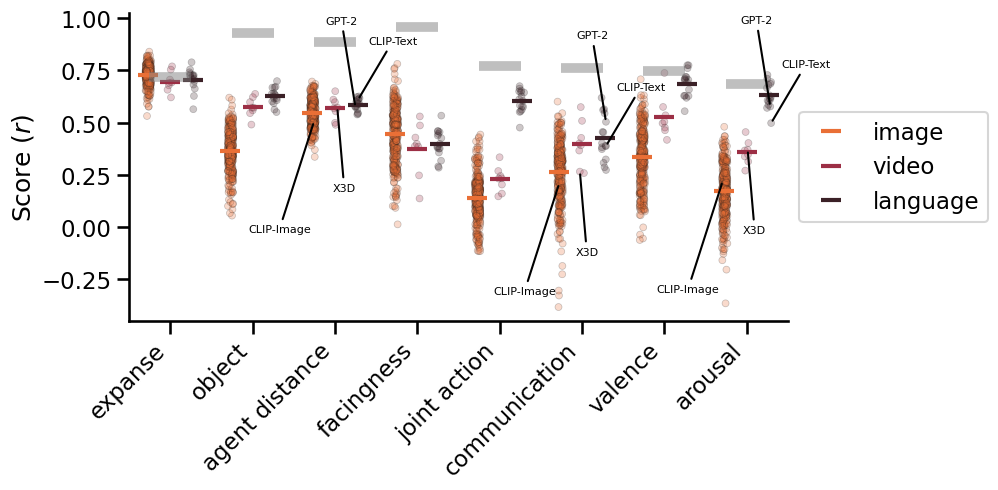

In [119]:
paths = [f'../data/interim/VisionBehaviorEncoding/grouped_average/*.csv.gz',
         f'../data/interim/LanguageBehaviorEncoding/no_perturbation/*.*.gz',
         f'../data/interim/VideoBehaviorEncoding/*.*.gz']
scores = load_all_files(paths)
max_scores = combined_behavior_max(scores)
uids = ['slip_vit_b_clip_yfcc15m','x3d_s',
        'gpt2', 'sentence-transformers_clip-ViT-B-32-multilingual-v1']
names = ['CLIP-Image', 'X3D', 'GPT-2', 'CLIP-Text']
af = ['agent distance', 'communication', 'arousal']
plot_combined_behavior_summary(max_scores, behavior_reliability, annotations=True, 
                               model_uids_to_annotate=uids,
                               model_name_to_show=names,
                               annotation_features=af)

#### SLIP

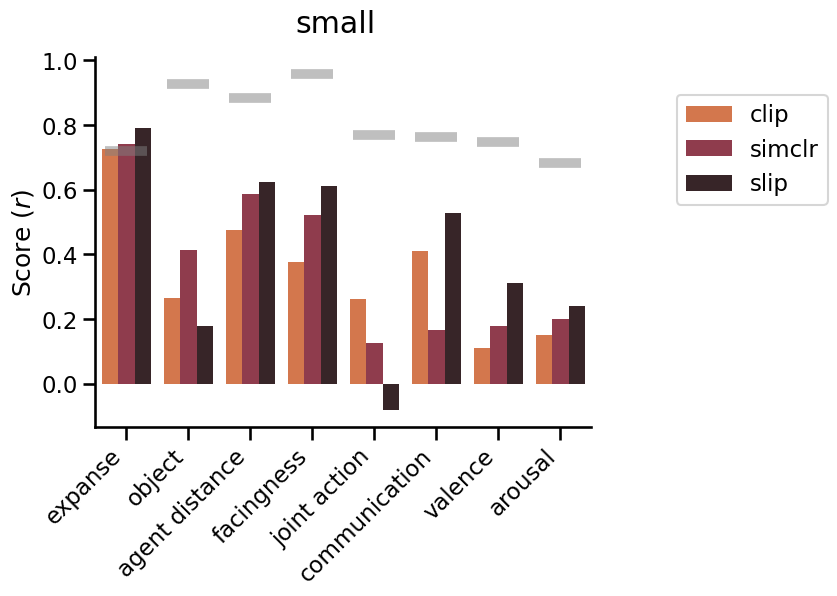

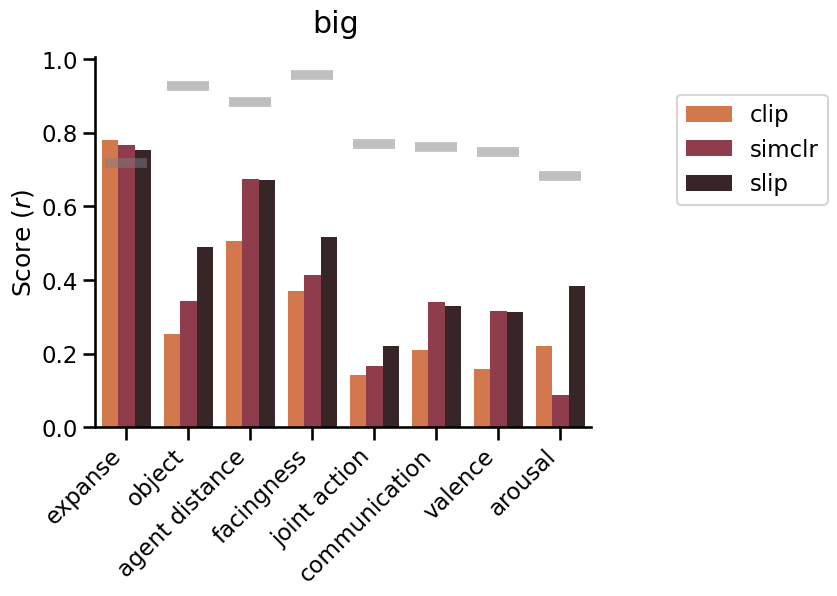

In [120]:
behavior_slip_plot(clean_slip(max_scores, 'slip_vit_s'),
                   behavior_reliability, title='small')
behavior_slip_plot(clean_slip(max_scores, 'slip_vit_b'),
                   behavior_reliability, title='big')

#### Model table

In [131]:
model_avg_score = max_scores.groupby('model_uid').mean(numeric_only=True)
best_model = model_avg_score.nlargest(1, 'test_score').index.tolist()[0]
print(f'The best behavioral model on average is {best_model}')
best_models = model_avg_score.nlargest(10, 'test_score').index.tolist()
best_model_scores = max_scores.loc[max_scores.model_uid.isin(best_models)].reset_index(drop=True)
pivot_df = best_model_scores.pivot(index='model_uid', columns='feature', values='test_score')
pivot_df = pivot_df.reindex(best_models)
pivot_df

The best behavioral model on average is sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2


feature,expanse,object,agent distance,facingness,joint action,communication,valence,arousal
model_uid,,,,,,,,
sentence-transformers_paraphrase-multilingual-MiniLM-L12-v2,0.722879,0.638100,0.590453,0.533619,0.649570,0.564118,0.693159,0.620986
sentence-transformers_paraphrase-MiniLM-L6-v2,0.754731,0.624409,0.578098,0.438138,0.577244,0.619065,0.702142,0.694538
sentence-transformers_paraphrase-multilingual-mpnet-base-v2,0.732087,0.617049,0.612614,0.460359,0.653244,0.560629,0.706759,0.616339
sentence-transformers_all-mpnet-base-v2,0.707086,0.668042,0.542246,0.458688,0.674666,0.382377,0.719447,0.728063
sentence-transformers_all-mpnet-base-v1,0.724216,0.698968,0.589972,0.376668,0.644256,0.401949,0.718104,0.665826
sentence-transformers_all-roberta-large-v1,0.789022,0.631759,0.592355,0.446334,0.645160,0.373357,0.627552,0.680791
sentence-transformers_all-distilroberta-v1,0.698356,0.601393,0.563338,0.455140,0.603841,0.389498,0.774881,0.611795
sentence-transformers_distiluse-base-multilingual-cased-v1,0.710263,0.671831,0.578131,0.317930,0.476224,0.453416,0.760609,0.685955
clip_vitl14,0.769112,0.539516,0.622161,0.781259,0.306811,0.492300,0.707763,0.403530


In [132]:
def highlight_max(row):
    # row.index and row are passed, where row.index corresponds to column names in the original DataFrame
    out = [row.name]  # Start with the model_uid, which is the name of the row after setting the index to 'model_uid'
    for key, value in row.items():
        if np.isclose(value, best_model_score_per_feature.loc[key]):
            out.append(f'\\textbf{{{value:.3f}}}')
        else: 
            out.append(f'{value:.3f}')
    return f"{' & '.join(out)} \\\\"

best_model_score_per_feature = max_scores.groupby('feature', observed=True)['test_score'].max()
best_model_score_per_feature = pd.DataFrame(best_model_score_per_feature)

# Preprocessing and renaming
pivot_df.reset_index(inplace=True)
rename_model = {model: model.replace('sentence-transformers_', '') for model in pivot_df['model_uid'].unique()}
pivot_df['model_uid'] = pivot_df['model_uid'].replace(rename_model)
pivot_df.set_index('model_uid', inplace=True)  # Set 'model_uid' as the index for use in the function

# Applying highlight function
formatted_df = pivot_df.apply(highlight_max, axis=1)

# Convert DataFrame to LaTeX
annotated_features = ['expanse', 'object', 'agent distance', 'facingness', 'joint action', 'communication', 'valence', 'arousal']
latex_str = '\\begin{tabular}{l' + 'c' * len(annotated_features) + '}\\toprule\n'
latex_str += 'Model UID & ' + ' & '.join(annotated_features) + ' \\\\\\midrule\n'
latex_str += '\n'.join(formatted_df) + '\n\\bottomrule\n\\end{tabular}'
latex_str = latex_str.replace('_', '\\_')

print(latex_str)

\begin{tabular}{lcccccccc}\toprule
Model UID & expanse & object & agent distance & facingness & joint action & communication & valence & arousal \\\midrule
paraphrase-multilingual-MiniLM-L12-v2 & 0.723 & 0.638 & 0.590 & 0.534 & 0.650 & 0.564 & 0.693 & 0.621 \\
paraphrase-MiniLM-L6-v2 & 0.755 & 0.624 & 0.578 & 0.438 & 0.577 & \textbf{0.619} & 0.702 & 0.695 \\
paraphrase-multilingual-mpnet-base-v2 & 0.732 & 0.617 & 0.613 & 0.460 & 0.653 & 0.561 & 0.707 & 0.616 \\
all-mpnet-base-v2 & 0.707 & 0.668 & 0.542 & 0.459 & \textbf{0.675} & 0.382 & 0.719 & \textbf{0.728} \\
all-mpnet-base-v1 & 0.724 & \textbf{0.699} & 0.590 & 0.377 & 0.644 & 0.402 & 0.718 & 0.666 \\
all-roberta-large-v1 & 0.789 & 0.632 & 0.592 & 0.446 & 0.645 & 0.373 & 0.628 & 0.681 \\
all-distilroberta-v1 & 0.698 & 0.601 & 0.563 & 0.455 & 0.604 & 0.389 & \textbf{0.775} & 0.612 \\
distiluse-base-multilingual-cased-v1 & 0.710 & 0.672 & 0.578 & 0.318 & 0.476 & 0.453 & 0.761 & 0.686 \\
clip\_vitl14 & 0.769 & 0.540 & 0.622 & \textbf{0

#### Model input

In [ ]:
max_scores_indexed = max_scores.set_index(['feature', 'model_class', 'model_uid']).sort_index()
models = max_scores_indexed.loc['communication', 'image']['test_score'].sort_values()

# Take every other vision model
model_ind = int(len(models)/2)
filtered_models = models.index[model_ind:].tolist()
filtered_models += max_scores_indexed.loc['communication', 'video'].index.tolist()
filtered_models += max_scores_indexed.loc['communication', 'language'].index.tolist()
max_scores_filtered = max_scores[max_scores.model_uid.isin(filtered_models)]

In [ ]:
plot_model_oder(max_scores_filtered, 'feature', 'model_class')

#### Vision Architecture

In [ ]:
model_list = load_single_file(f'../data/raw/model_list/vision_models.csv')
max_scores_info = model_list.merge(max_scores_filtered, left_on='Model UID', right_on='model_uid')
plot_model_oder(max_scores_info, 'feature', 'Architecture Type')

#### Task Cluster

In [ ]:
max_scores_info.replace({'Self-Supervision': 'Self-Supervised',
                         'SelfSupervised': 'Self-Supervised',
                         'Vision-Language': 'Multimodal'}, inplace=True)
plot_model_oder(max_scores_info, 'feature', 'Task Cluster')

### Neural

#### Load and basic plotting

354 files found


Loading files:  97%|█████████▋| 342/354 [02:15<01:01,  5.13s/it]

could not load model-sentence-transformers_all-MiniLM-L6-v2.pkl.gz


Loading files:  97%|█████████▋| 345/354 [02:26<00:45,  5.06s/it]

could not load model-sentence-transformers_all-mpnet-base-v2.pkl.gz


Loading files: 100%|██████████| 354/354 [02:27<00:00,  2.39it/s]


['gpt2', 'timm_beitv2_large_patch16_224', 'c2d_r50', 'sentence-transformers_distiluse-base-multilingual-cased-v1']


/tmp/ipykernel_2674075/111024298.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2674075/111024298.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],


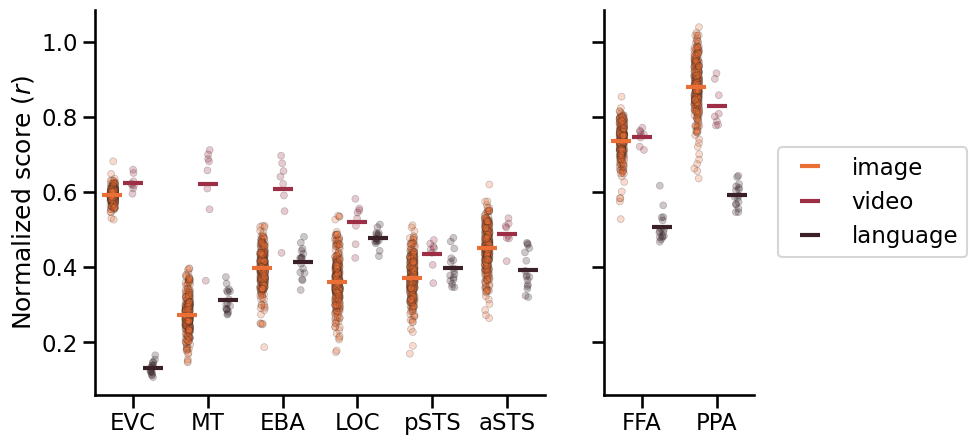

In [99]:
paths = [f'../data/interim/VisionNeuralEncoding/grouped_average/*.csv.gz',
         f'../data/interim/LanguageNeuralEncoding/no_perturbation/*.*.gz',
         f'../data/interim/VideoNeuralEncoding/*.*.gz']
scores = load_all_files(paths)
max_scores = combined_neural_max(scores)
plot_combined_normalized_neural(max_scores)

/tmp/ipykernel_2674075/4227009801.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2674075/4227009801.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],


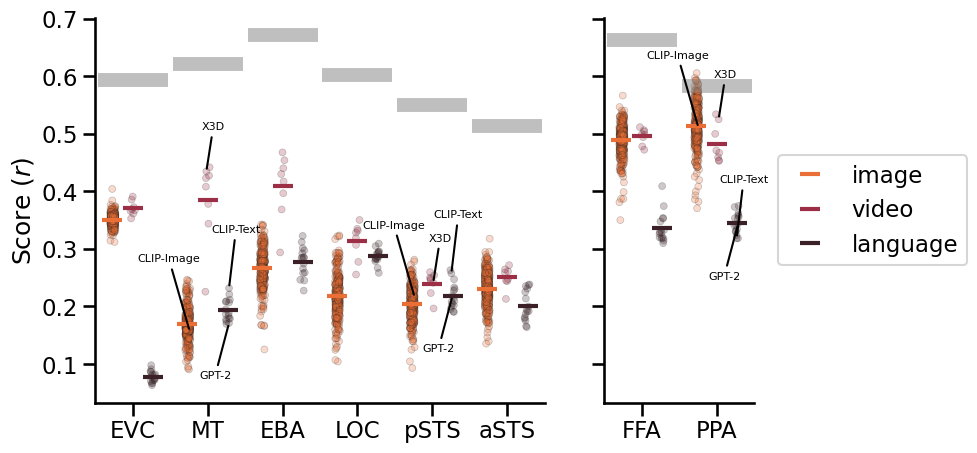

In [100]:
uids = ['slip_vit_b_clip_yfcc15m','x3d_s',
        'gpt2', 'sentence-transformers_clip-ViT-B-32-multilingual-v1']
names = ['CLIP-Image', 'X3D', 'GPT-2', 'CLIP-Text']
plot_combined_neural(max_scores, annotations=True, 
                     model_uids_to_annotate=uids,
                     model_name_to_show=names,
                     annotation_rois=['MT', 'pSTS', 'PPA'])

#### SLIP

/tmp/ipykernel_2674075/263264944.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2674075/263264944.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2674075/263264944.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

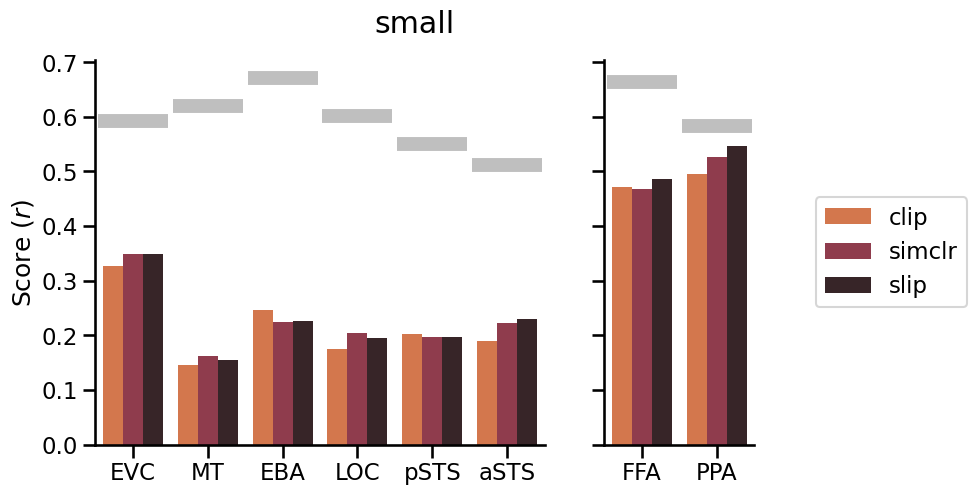

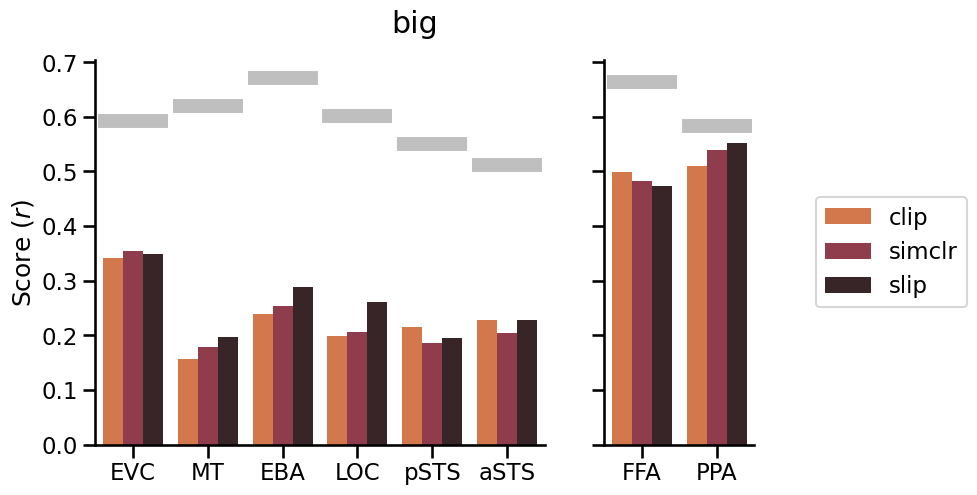

In [101]:
neural_slip_plot(clean_slip(max_scores, 'slip_vit_s'), title='small')
neural_slip_plot(clean_slip(max_scores, 'slip_vit_b'), title='big')

#### Find best model per voxel

In [106]:
# def calculate_mode(group):
#     model_uid_counts = group['model_uid'].value_counts()
#     most_frequent_model_uid = model_uid_counts.idxmax()
#     count = model_uid_counts.max()
#     return pd.Series([most_frequent_model_uid, count], index=['most_frequent_model_uid', 'count'])

# best_model_info = max_scores.groupby('model_class').apply(calculate_mode)
# best_model_info.to_csv(f'{out_path}/overall_best_model.csv')
# print('Best models of each class:')
# best_model_info

Best models of each class:


/tmp/ipykernel_2674075/1155869892.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_model_info = max_scores.groupby('model_class').apply(calculate_mode)


,most_frequent_model_uid,count
model_class,,
image,vissl_resnet50_swav,8
video,c2d_r50,8
language,gpt2,8


#### Model table

In [117]:
model_avg_score = max_scores.groupby('model_uid').mean(numeric_only=True)
best_models = model_avg_score.nlargest(10, 'test_score').index.tolist()
best_model_scores = max_scores.loc[max_scores.model_uid.isin(best_models)]
pivot_df = best_model_scores.pivot(index='model_uid', columns='roi_name', values='test_score')
pivot_df = pivot_df.reindex(best_models)
pivot_df

roi_name,EVC,MT,EBA,LOC,pSTS,aSTS,FFA,PPA
model_uid,,,,,,,,
x3d_m,0.385587,0.427086,0.467505,0.334767,0.247737,0.264440,0.503872,0.499734
x3d_s,0.390860,0.434568,0.429946,0.350190,0.241083,0.247778,0.499239,0.525037
i3d_r50,0.367054,0.422824,0.453913,0.331491,0.254322,0.261019,0.498532,0.452799
slowfast_r50,0.365736,0.441649,0.440077,0.318728,0.250114,0.259052,0.477942,0.453703
slow_r50,0.361302,0.408001,0.417062,0.328306,0.245664,0.244900,0.511452,0.470944
timm_beitv2_large_patch16_224,0.372235,0.243696,0.339940,0.323265,0.281296,0.289773,0.529658,0.582411
c2d_r50,0.372420,0.377989,0.396609,0.306990,0.259662,0.271745,0.506163,0.459194
timm_mixer_b16_224_miil_in21k,0.404072,0.210423,0.307192,0.258747,0.262668,0.317764,0.566208,0.605287
timm_beit_large_patch16_224,0.370767,0.245321,0.342302,0.317000,0.272816,0.280781,0.508358,0.589449


In [118]:
def highlight_max(row):
    # row.index and row are passed, where row.index corresponds to column names in the original DataFrame
    out = [row.name]  # Start with the model_uid, which is the name of the row after setting the index to 'model_uid'
    for key, value in row.items():
        if np.isclose(value, best_model_score_per_feature.loc[key]):
            out.append(f'\\textbf{{{value:.3f}}}')
        else: 
            out.append(f'{value:.3f}')
    return f"{' & '.join(out)} \\\\"

best_model_score_per_feature = max_scores.groupby('roi_name', observed=True)['test_score'].max()
best_model_score_per_feature = pd.DataFrame(best_model_score_per_feature)

# Preprocessing and renaming
pivot_df.reset_index(inplace=True)
rename_model = {model: model.replace('sentence-transformers_', '') for model in pivot_df['model_uid'].unique()}
pivot_df['model_uid'] = pivot_df['model_uid'].replace(rename_model)
rename_model = {model: model.replace('timm_', '') for model in pivot_df['model_uid'].unique()}
pivot_df['model_uid'] = pivot_df['model_uid'].replace(rename_model)
pivot_df.set_index('model_uid', inplace=True)  # Set 'model_uid' as the index for use in the function

# Applying highlight function
formatted_df = pivot_df.apply(highlight_max, axis=1)

# Convert DataFrame to LaTeX
latex_str = '\\begin{tabular}{l' + 'c' * len(rois) + '}\\toprule\n'
latex_str += 'Model UID & ' + ' & '.join(rois) + ' \\\\\\midrule\n'
latex_str += '\n'.join(formatted_df) + '\n\\bottomrule\n\\end{tabular}'
latex_str = latex_str.replace('_', '\\_')

print(latex_str)

\begin{tabular}{lcccccccc}\toprule
Model UID & EVC & MT & EBA & LOC & pSTS & aSTS & FFA & PPA \\\midrule
x3d\_m & 0.386 & 0.427 & \textbf{0.468} & 0.335 & 0.248 & 0.264 & 0.504 & 0.500 \\
x3d\_s & 0.391 & 0.435 & 0.430 & \textbf{0.350} & 0.241 & 0.248 & 0.499 & 0.525 \\
i3d\_r50 & 0.367 & 0.423 & 0.454 & 0.331 & 0.254 & 0.261 & 0.499 & 0.453 \\
slowfast\_r50 & 0.366 & \textbf{0.442} & 0.440 & 0.319 & 0.250 & 0.259 & 0.478 & 0.454 \\
slow\_r50 & 0.361 & 0.408 & 0.417 & 0.328 & 0.246 & 0.245 & 0.511 & 0.471 \\
beitv2\_large\_patch16\_224 & 0.372 & 0.244 & 0.340 & 0.323 & \textbf{0.281} & 0.290 & 0.530 & 0.582 \\
c2d\_r50 & 0.372 & 0.378 & 0.397 & 0.307 & 0.260 & 0.272 & 0.506 & 0.459 \\
mixer\_b16\_224\_miil\_in21k & \textbf{0.404} & 0.210 & 0.307 & 0.259 & 0.263 & \textbf{0.318} & \textbf{0.566} & \textbf{0.605} \\
beit\_large\_patch16\_224 & 0.371 & 0.245 & 0.342 & 0.317 & 0.273 & 0.281 & 0.508 & 0.589 \\
beitv2\_base\_patch16\_224 & 0.363 & 0.224 & 0.342 & 0.322 & 0.262 & 0.252 & 0.52

#### Model Input

In [ ]:
max_scores_indexed = max_scores.set_index(['roi_name', 'model_class', 'model_uid']).sort_index()
models = max_scores_indexed.loc['pSTS', 'image']['test_score'].sort_values()

# Take every other vision model
model_ind = int(len(models)/2)
filtered_models = models.index[model_ind:].tolist()
filtered_models += max_scores_indexed.loc['pSTS', 'video'].index.tolist()
filtered_models += max_scores_indexed.loc['pSTS', 'language'].index.tolist()
max_scores_filtered = max_scores[max_scores.model_uid.isin(filtered_models)]

In [ ]:
plot_model_oder(max_scores_filtered, 'roi_name', 'model_class')

#### Vision Architecture

In [ ]:
model_list = load_single_file(f'../data/raw/model_list/vision_models.csv')
max_scores_info = model_list.merge(max_scores_filtered, left_on='Model UID', right_on='model_uid')
plot_model_oder(max_scores_info, 'roi_name', 'Architecture Type')

#### Task Cluster

In [ ]:
max_scores_info.replace({'Self-Supervision': 'Self-Supervised',
                         'SelfSupervised': 'Self-Supervised',
                         'Vision-Language': 'Multimodal'}, inplace=True)
plot_model_oder(max_scores_info, 'roi_name', 'Task Cluster')

## Perturbation experiments

In [ ]:
def plot_perturbation_summary(df_, reliability_, out_file=None,
                              y_var='test_score', y_label='Score ($r$)', 
                              plot_reliability=True,
                              palette_name=None):
    if palette_name is None:
        palette = sns.color_palette("husl", df_.perturbation.nunique())
    else:
        palette = sns.color_palette(palette_name, df_.perturbation.nunique())
    _, ax = plt.subplots(figsize=(8.5,4))
    color = ['gray', 'gray', 'gray']
    sns.stripplot(x='feature', y=y_var, hue='perturbation', data=df_,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  zorder=1, palette=palette)
    sns.barplot(x='feature', y=y_var, hue='perturbation', data=df_,
                dodge=True, saturation=.25, errorbar=None,
                legend=False, zorder=0, palette=palette)
    if plot_reliability:
        sns.pointplot(x='feature', y='reliability', data=reliability_,
                      ax=ax, linestyle="none", errorbar=None, 
                      marker="_", markersize=30, markeredgewidth=7,
                      color='gray', alpha=.5, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ticks = ax.get_xticks()
    labels = [label.get_text() for label in ax.get_xticklabels()]
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(y_label)
    # ax.set_ylim([-0.6, .1])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
              ncol=1, fancybox=True)
    if out_file is not None:
        plt.savefig(out_file)

In [ ]:
paths = ['../data/interim/LanguageBehaviorEncoding/perturbation/*/model*.*.gz',
         '../data/interim/LanguageBehaviorEncoding/no_perturbation/model*.*.gz']
scores = load_all_files(paths, perturbation=True)
max_scores = perturbation_behavior_max(scores)
plot_perturbation_summary(max_scores, behavior_reliability, )

In [ ]:
score_diff = max_scores.copy()
grouped = score_diff.groupby('feature', observed=True)
score_diff['test_score_diff'] = grouped['test_score'].transform(lambda x: x - x[score_diff['perturbation'] == 'original'].values[0])
score_diff = score_diff[score_diff['perturbation'] != 'none']

for perturbs in [['no nouns', 'no verbs'],['only verbs', 'only nouns']]: 
    cur_diff = score_diff.loc[score_diff['perturbation'].isin(perturbs)].reset_index()
    cur_diff['perturbation'] = pd.Categorical(cur_diff['perturbation'], categories=perturbs, ordered=True)
    plot_perturbation_summary(cur_diff, behavior_reliability,
                              y_var='test_score_diff', y_label='Performance decrease ($r$)', 
                              plot_reliability=False, palette_name='Set2')

## Statistics

In [ ]:
def mean_of_arrays(series):
    # Stack arrays vertically and compute mean along the first axis (rows)
    return np.nanmean(np.vstack(series),axis=0)

def compute_confidence_intervals(arr):
    lower = np.nanpercentile(arr, 2.5)
    upper = np.nanpercentile(arr, 97.5)
    return lower, upper

def calculate_p_df(row):
    from src.stats import calculate_p
    r_value = row['test_score']  # The 'r' value for the current row
    r_null_array = row['r_null_dist']  # The 'r_null' array for the current row
    return calculate_p(r_null_array, r_value, n_perm_=len(r_null_array), H0_='greater')

In [26]:
def func(model_class='VisionNeuralEncoding',
         model_subpath='grouped_average'):
    single_file = glob(f'../data/interim/{model_class}/{model_subpath}/*.gz')[-1]
    single_model = pd.read_pickle(single_file)[['voxel_id', 'roi_name']]
    if 'roi_name' in single_model.columns: 
        single_model = single_model.loc[single_model.roi_name != 'none'].reset_index(drop=True)

    df = pd.read_pickle(f'../data/interim/ModelAveraging/{model_class}_{model_subpath}.pkl.gz')
    df = df.merge(single_model, on='voxel_id')

    result = df.groupby(['roi_name']).agg({
        'test_score': 'mean',  # For scalar values, use the built-in 'mean' function
        'train_score': 'mean',  # For numpy arrays, use the custom function
        'layer_relative_depth': 'mean',
        'r_null_dist': mean_of_arrays,
        'r_var_dist': mean_of_arrays,
    }).reset_index()

    result[['lower_ci', 'upper_ci']] = result['r_var_dist'].apply(lambda arr: pd.Series(compute_confidence_intervals(arr)))

    # Calculate the p values across subjects
    result['p'] = result.apply(calculate_p_df, axis=1)
    return result

In [28]:
df = pd.read_csv('../data/interim/ModelROISummary/VisionNeuralEncoding_grouped_average.csv.gz')

/tmp/ipykernel_2815552/954820961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2815552/954820961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],


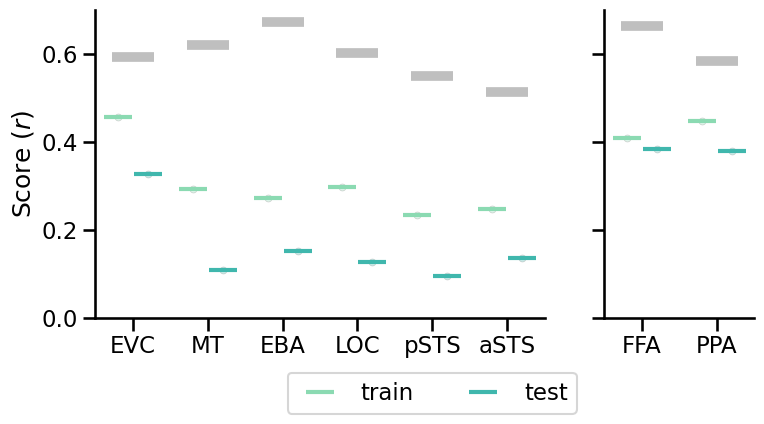

In [44]:
plot_neural_summary(df)